In this notebook we will apply Strategy 2 for transfer learning. When using this strategy we train some layers while leaving other layers frozen.

This technique is indicated in two cases:

1. **Large dataset and similar to the pre-trained model dataset:** Since the dataset is large  overfitting shouldn’t be an issue, so we can learn as much as we want. However, since the datasets are similar, we can save ourselves from a huge training effort by leveraging previous knowledge. Therefore, it should be enough to train the classifier and the top layers of the convolutional base.

2. **Small dataset and similar to the pre-trained model dataset:** In this case is a challenge to find a balance between the number of layers to train and freeze.  This because on one side, if you go to deep you risk overfitting while on the other side, if not the model will not learn enough. Data augmentation is a technique that should be considered in order to fight overfitting and allow the model to learn enough.

This method is known as `Fine-tuning`. `Fine-tuning` is widely used technique for model reuse and complementary to feature extraction. 

Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (the classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In addition, because our dataset is small we will make use of data augmentation.

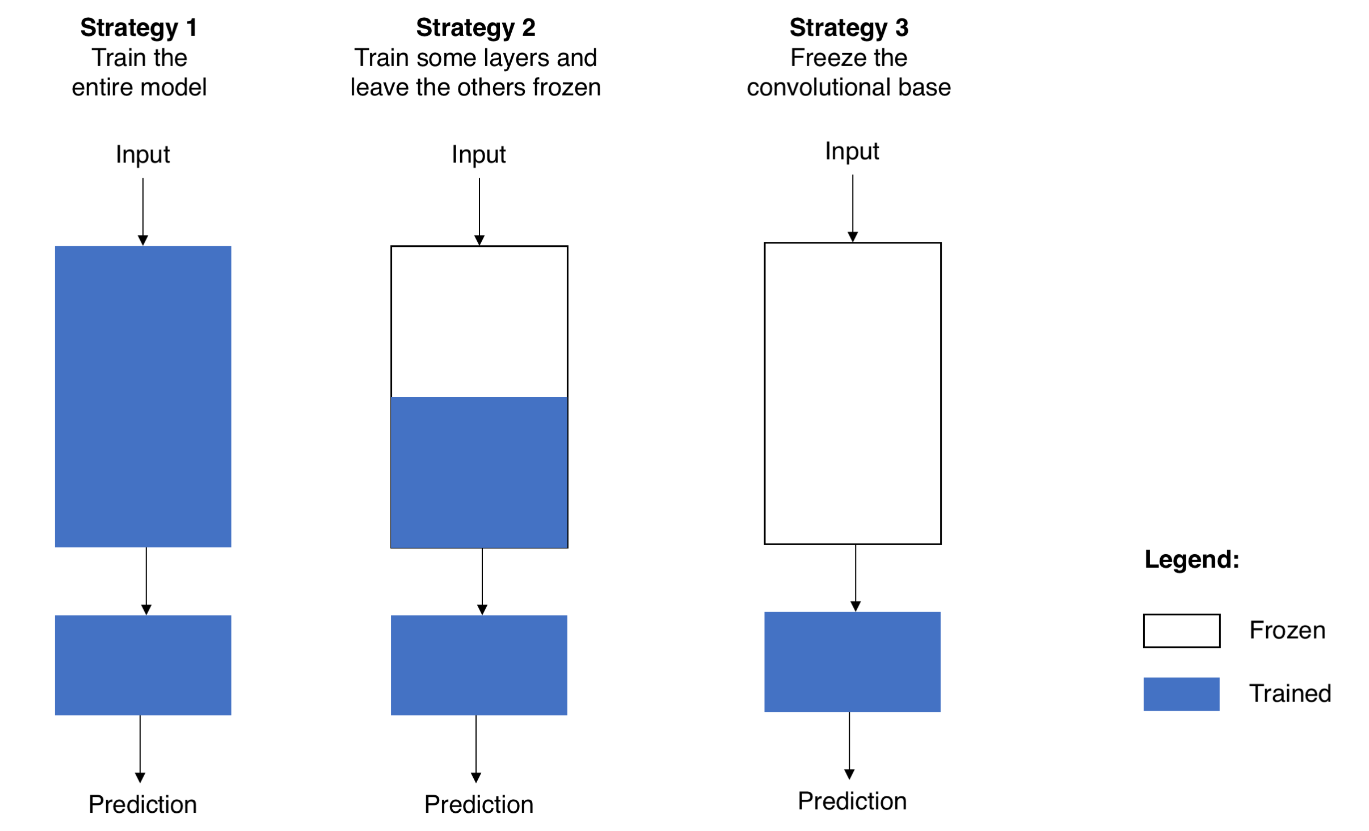

In [1]:
from IPython.display import Image
Image("strategies.png")

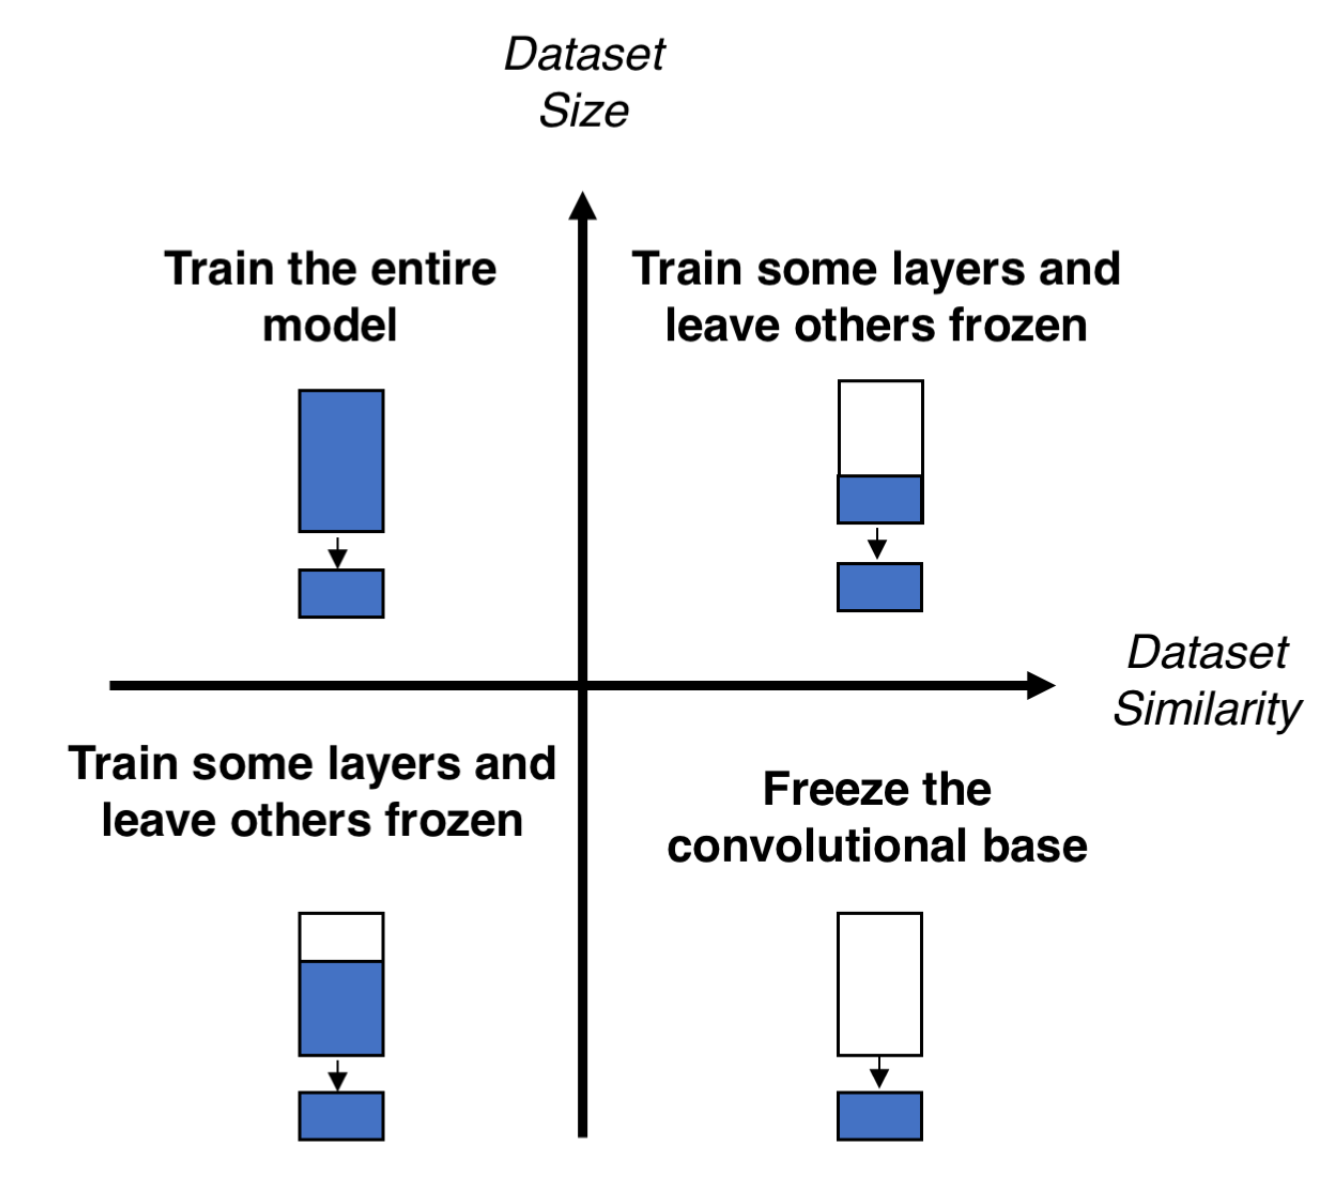

In [2]:
from IPython.display import Image
Image("approaches.png")

It is necessary to freeze the convolution base of the pre-trained network in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already be trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

**Step1** Add your custom network on top of an already trained base network.

**Step2** Freeze the base network.

**Step3** Train the part you added (Classifier).

**Step4** Unfreeze some layers in the base network.

**Step5** Jointly train both these layers and the part you added.

# The Convolutional Base (conv_base)

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for ResNet152V2 is 224,224

In [4]:
# Instantiate convolutional base

from keras.applications.resnet_v2 import ResNet152V2

conv_base = ResNet152V2(include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        input_shape=(img_width, img_height, img_channels))


Using TensorFlow backend.


In [5]:
conv_base.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [6]:
conv_base.input_shape

(None, 128, 128, 3)

# Data preparation - Data augmentation

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All imgs will be resized to img_height x img_width
        target_size=(img_height, img_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


# Fully Connected Layers (FCL) classifier

## Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [8]:
# Define model

from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 4, 4, 2048)        58331648  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 66,720,769
Trainable params: 66,577,025
Non-trainable params: 143,744
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 516


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 resnet152v2 False
1 flatten_1 True
2 dense_1 True
3 dropout_1 True
4 dense_2 True


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with data augmentation.

## Compile model

In [13]:
import pandas as pd

def info_layers(conv_base,model):
    
    list_layer_name = []
    list_trainable = []

    for layer in conv_base.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    

    df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    list_layer_name = []
    list_trainable = []

    for layer in model.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    
    df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    df2 = df2[1:]

    df= pd.concat([df1,df2])
    df.reset_index(drop=True,inplace=True)
    
    pd.options.display.max_rows = len(df)
    
    return df

In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d_1 T

317 conv4_block17_out True
318 conv4_block18_preact_bn True
319 conv4_block18_preact_relu True
320 conv4_block18_1_conv True
321 conv4_block18_1_bn True
322 conv4_block18_1_relu True
323 conv4_block18_2_pad True
324 conv4_block18_2_conv True
325 conv4_block18_2_bn True
326 conv4_block18_2_relu True
327 conv4_block18_3_conv True
328 conv4_block18_out True
329 conv4_block19_preact_bn True
330 conv4_block19_preact_relu True
331 conv4_block19_1_conv True
332 conv4_block19_1_bn True
333 conv4_block19_1_relu True
334 conv4_block19_2_pad True
335 conv4_block19_2_conv True
336 conv4_block19_2_bn True
337 conv4_block19_2_relu True
338 conv4_block19_3_conv True
339 conv4_block19_out True
340 conv4_block20_preact_bn True
341 conv4_block20_preact_relu True
342 conv4_block20_1_conv True
343 conv4_block20_1_bn True
344 conv4_block20_1_relu True
345 conv4_block20_2_pad True
346 conv4_block20_2_conv True
347 conv4_block20_2_bn True
348 conv4_block20_2_relu True
349 conv4_block20_3_conv True
350 conv4_

In [15]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,conv1_pad,True
2,conv1_conv,True
3,pool1_pad,True
4,pool1_pool,True
5,conv2_block1_preact_bn,True
6,conv2_block1_preact_relu,True
7,conv2_block1_1_conv,True
8,conv2_block1_1_bn,True
9,conv2_block1_1_relu,True


In [16]:
conv_base.trainable = True

for layer in conv_base.layers[:528]:
    layer.trainable = False

In [17]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,conv1_pad,False
2,conv1_conv,False
3,pool1_pad,False
4,pool1_pool,False
5,conv2_block1_preact_bn,False
6,conv2_block1_preact_relu,False
7,conv2_block1_1_conv,False
8,conv2_block1_1_bn,False
9,conv2_block1_1_relu,False


In [18]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [19]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-28 08:11:17.926699


In [20]:
# Train model

# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 839s 8s/step - loss: 0.7862 - acc: 0.6976 - val_loss: 0.6404 - val_acc: 0.7621
Epoch 2/30
100/100 [==============================] - 805s 8s/step - loss: 0.7323 - acc: 0.7145 - val_loss: 1.2067 - val_acc: 0.7652
Epoch 3/30
100/100 [==============================] - 786s 8s/step - loss: 0.6709 - acc: 0.7077 - val_loss: 0.4882 - val_acc: 0.7621
Epoch 4/30
100/100 [==============================] - 794s 8s/step - loss: 0.6831 - acc: 0.7040 - val_loss: 0.4473 - val_acc: 0.7429
Epoch 5/30
100/100 [==============================] - 894s 9s/step - loss: 0.6157 - acc: 0.7275 - val_loss: 0.2251 - val_acc: 0.7712
Epoch 6/30
100/100 [==============================] - 931s 9s/step - loss: 0.5730 - acc: 0.7320 - val_loss: 0.8329 - val_acc: 0.7622
Epoch 7/30
100/100 [==============================] - 964s 10s/step - loss: 0.6137 - acc: 0.7455 - val_loss: 0.6225 - val_acc: 0.7631
Epoch 8/30
100/100 [==============================] - 984s 10s/step 

## Save model

In [21]:
model.save("../models/ResNet152V2_firebreak_detection_fine_tuning_FC_model.h5")

## Model evaluation

### Learning curves

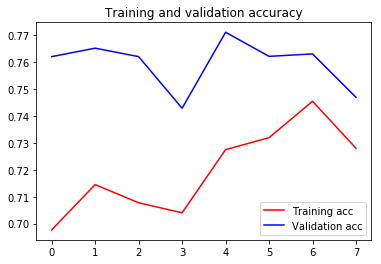

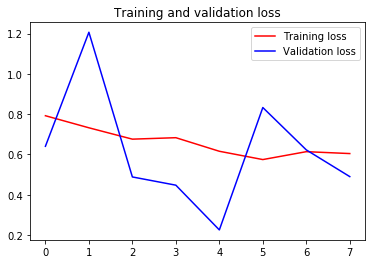

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/ResNet152V2_firebreak_detection_fine_tuning_FC_history.csv", index = False)

In [24]:
t2 = datetime.datetime.now()
print(t2)
print(t2-t1)

2019-11-28 10:08:14.184420
1:56:56.257721


### Model in action

In [25]:
def prediction_dataframe(generator):
    """ Generate dataframe with filename, probability, and class of the image
    """
    

    # Predict from generator (returns probabilities)
    pred=model.predict_generator(generator, steps=len(generator), verbose=1)

    # Get classes by np.round
    cl = np.round(pred)
    # Get filenames (set shuffle=false in generator is important)
    filenames=generator.filenames

    # Data frame
    results=pd.DataFrame({"file_name":filenames,"prob":pred[:,0], "class":cl[:,0]})
    results['file_name'] = results['file_name'].apply(lambda x: x.split('\\')[-1])
    
    return results

In [26]:
# obtaining predictions for test images

results = prediction_dataframe(test_generator)
results.head()

32/32 [==============================] - 188s 6s/step


,file_name,prob,class
0,2017-12-12 11-56-38_NAO.jpeg,0.194916,0.0
1,2018-01-09 16-17-15_NAO.jpeg,0.315041,0.0
2,2018-01-09 17-10-54_NAO.jpeg,0.235613,0.0
3,2018-01-30 08-53-00_NAO.jpeg,0.134413,0.0
4,2018-01-30 09-07-13_NAO.jpeg,0.016249,0.0


In [27]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases, results):
    """ shows images and prediction considering threshold of 0.5 and test images"""
    
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Make prediction
        
        idx = results.index[results['file_name'] == random_img].tolist()
        prediction = results['prob'].loc[idx[0]]

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

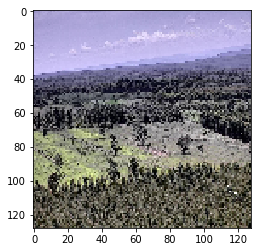

2018-03-21 11-07-29_NAO.jpeg
Firebreak


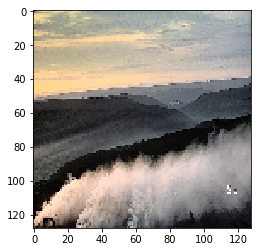

2018-03-04 06-02-16_SIM.jpeg
Not firebreack


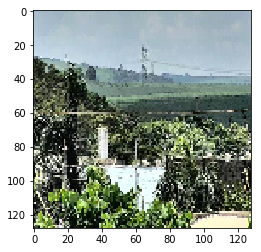

2018-01-31 14-11-39_NAO.jpeg
Firebreak


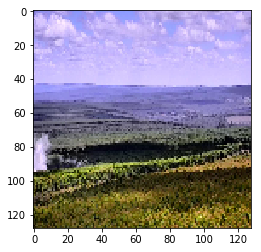

2019-01-31 11-29-23_SIM.jpeg
Not firebreack


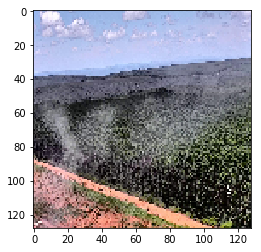

2018-03-21 11-48-57_SIM.jpeg
Not firebreack


In [28]:
# Visualize predictions
visualize_predictions(model, 5, results)

# Global average pooling

## Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [30]:
# Instantiate convolutional base

from keras.applications.resnet_v2 import ResNet152V2

conv_base = ResNet152V2(include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        input_shape=(img_width, img_height, img_channels))

conv_base.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

conv4_block36_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      conv4_block36_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block36_out (Add)         (None, 4, 4, 1024)   0           max_pooling2d_6[0][0]            
                                                                 conv4_block36_3_conv[0][0]       
__________________________________________________________________________________________________
conv5_block1_preact_bn (BatchNo (None, 4, 4, 1024)   4096        conv4_block36_out[0][0]          
__________________________________________________________________________________________________
conv5_block1_preact_relu (Activ (None, 4, 4, 1024)   0           conv5_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 4, 4, 512)    524288      conv5_block1_preact_relu[0][0]   
__________

In [31]:
# Define model

from keras import models
from keras import layers

#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 58,333,697
Trainable params: 58,189,953
Non-trainable params: 143,744
_________________________________________________________________


In [32]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 514


In [33]:
conv_base.trainable = False

In [34]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [35]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 resnet152v2
1 global_average_pooling2d_1
2 dense_3


## Compile model

In [36]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d_4 T

382 conv4_block23_3_conv True
383 conv4_block23_out True
384 conv4_block24_preact_bn True
385 conv4_block24_preact_relu True
386 conv4_block24_1_conv True
387 conv4_block24_1_bn True
388 conv4_block24_1_relu True
389 conv4_block24_2_pad True
390 conv4_block24_2_conv True
391 conv4_block24_2_bn True
392 conv4_block24_2_relu True
393 conv4_block24_3_conv True
394 conv4_block24_out True
395 conv4_block25_preact_bn True
396 conv4_block25_preact_relu True
397 conv4_block25_1_conv True
398 conv4_block25_1_bn True
399 conv4_block25_1_relu True
400 conv4_block25_2_pad True
401 conv4_block25_2_conv True
402 conv4_block25_2_bn True
403 conv4_block25_2_relu True
404 conv4_block25_3_conv True
405 conv4_block25_out True
406 conv4_block26_preact_bn True
407 conv4_block26_preact_relu True
408 conv4_block26_1_conv True
409 conv4_block26_1_bn True
410 conv4_block26_1_relu True
411 conv4_block26_2_pad True
412 conv4_block26_2_conv True
413 conv4_block26_2_bn True
414 conv4_block26_2_relu True
415 conv4_

In [37]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,conv1_pad,True
2,conv1_conv,True
3,pool1_pad,True
4,pool1_pool,True
5,conv2_block1_preact_bn,True
6,conv2_block1_preact_relu,True
7,conv2_block1_1_conv,True
8,conv2_block1_1_bn,True
9,conv2_block1_1_relu,True


In [38]:
conv_base.trainable = True

for layer in conv_base.layers[:528]:
    layer.trainable = False

In [39]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,conv1_pad,False
2,conv1_conv,False
3,pool1_pad,False
4,pool1_pool,False
5,conv2_block1_preact_bn,False
6,conv2_block1_preact_relu,False
7,conv2_block1_1_conv,False
8,conv2_block1_1_bn,False
9,conv2_block1_1_relu,False


In [40]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [41]:
# Train model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 1021s 10s/step - loss: 0.6652 - acc: 0.6180 - val_loss: 0.5714 - val_acc: 0.7379
Epoch 2/30
100/100 [==============================] - 941s 9s/step - loss: 0.5786 - acc: 0.7160 - val_loss: 0.4519 - val_acc: 0.7815
Epoch 3/30
100/100 [==============================] - 943s 9s/step - loss: 0.5489 - acc: 0.7572 - val_loss: 0.5037 - val_acc: 0.7641
Epoch 4/30
100/100 [==============================] - 940s 9s/step - loss: 0.5369 - acc: 0.7650 - val_loss: 0.3540 - val_acc: 0.7754
Epoch 5/30
100/100 [==============================] - 938s 9s/step - loss: 0.5148 - acc: 0.7819 - val_loss: 0.8233 - val_acc: 0.7651
Epoch 6/30
100/100 [==============================] - 931s 9s/step - loss: 0.5175 - acc: 0.7718 - val_loss: 0.6667 - val_acc: 0.7693
Epoch 7/30
100/100 [==============================] - 1064s 11s/step - loss: 0.4991 - acc: 0.7815 - val_loss: 0.5638 - val_acc: 0.7802


## Save model

In [42]:
model.save("../models/ResNet152V2_firebreak_detection_fine_tuning_GAP_model.h5")

# Model evaluation

## Learning curves

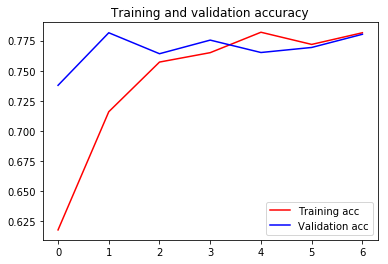

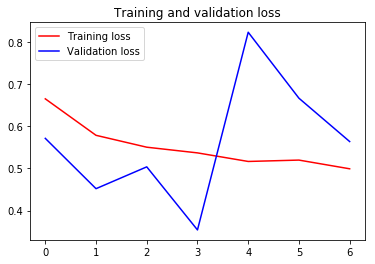

In [43]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/ResNet152V2_firebreak_detection_fine_tuning_GAP_history.csv", index = False)

In [45]:
t3 = datetime.datetime.now()
print(t3)
print(t3-t2)

2019-11-28 12:17:41.128634
2:09:26.944214


## Model in action

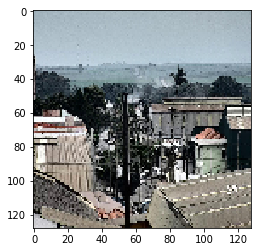

2018-01-09 17-10-54_NAO.jpeg
Not firebreack


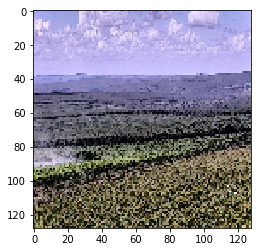

2018-03-15 13-37-45_SIM.jpeg
Not firebreack


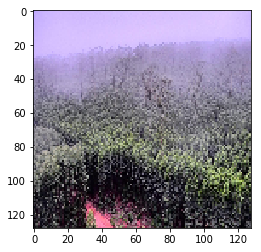

2018-12-28 13-07-04_SIM.jpeg
Not firebreack


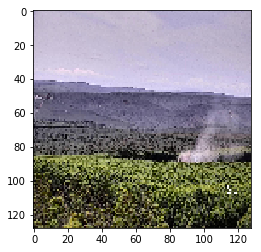

2018-03-01 09-16-38_NAO.jpeg
Firebreak


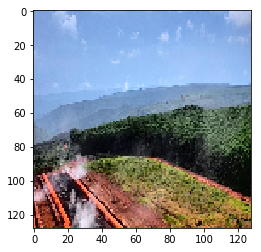

2019-02-07 15-15-51_NAO.jpeg
Not firebreack


In [46]:
# Visualize predictions
visualize_predictions(model, 5, results)

**REFERENCES**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks